In [1]:
# import packages
import numpy as np
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader, Subset, Dataset
from torchvision import datasets
from torchvision.transforms import v2, Lambda, ToTensor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

Exploratory data analysis

In [2]:
# import and download data
# transforms images from PIL image formate to normalized tensors - scales image's pixel intensity value from [0,1]
# transforms integer labels to one-hot encoded tensors
training_data_raw = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([
        v2.ToDtype(torch.float32, scale=True)
    ]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=v2.Compose([
        v2.ToDtype(torch.float32, scale=True)
    ]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

100%|██████████| 26421880/26421880 [00:02<00:00, 13163355.75it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207521.51it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3928516.08it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12289286.85it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# split training data into training and validation sets
X_train, X_vali, y_train, y_vali = train_test_split(
    training_data_raw.data, training_data_raw.targets, stratify = training_data_raw.targets,
    test_size=0.15, random_state = 4)

In [4]:
# descriptive statistics
labels = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# find number of samples from each class
[out_labels, inverse_indices, counts] = torch.unique(y_train, sorted=False, return_counts=True, return_inverse=True)

<function matplotlib.pyplot.show(close=None, block=None)>

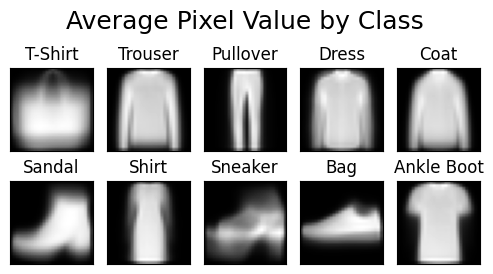

In [5]:
# get average of all pixels for each clothing type

# define figure/subplots
plt.figure(figsize=(5, 3))
#plt.subplots_adjust(hspace=0.1, wspace = 0.1)

plt.suptitle("Average Pixel Value by Class", fontsize=18, y=0.95)

nonzeros_count_avg = np.empty(10, dtype = 'object')
zeros_count_avg = np.empty(10, dtype = 'object')
avg_img_value = np.empty(20, dtype = 'object')
img_means = np.empty(10, dtype = 'object')

for n, i_label in enumerate(labels):
  # create mask of T/F to get indices that match class i_label
  mask = inverse_indices == i_label
  # index training data given mask
  t_class = X_train[mask]

  # get average number of black and non-black pixels for each class
  nonzeros_count_avg[n] = torch.count_nonzero(training_data_raw.transform(t_class))/counts[1]
  zeros_count_avg[n] = 28*28-nonzeros_count_avg[n]
  avg_img_value[n] = torch.mean(training_data_raw.transform(t_class))
  avg_img_value[n+10] = torch.std(training_data_raw.transform(t_class))


  # set axes and plot info
  ax = plt.subplot(2,5, n+1)
  img_means[n] = torch.mean(training_data_raw.transform(t_class), 0)
  ax.imshow(torch.mean(training_data_raw.transform(t_class), 0), cmap = "gray")
  ax.set_title(labels[i_label])
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout(h_pad = 1, w_pad=1)
plt.show

Text(0.5, 1.0, 'Average number of Non-Black Pixels')

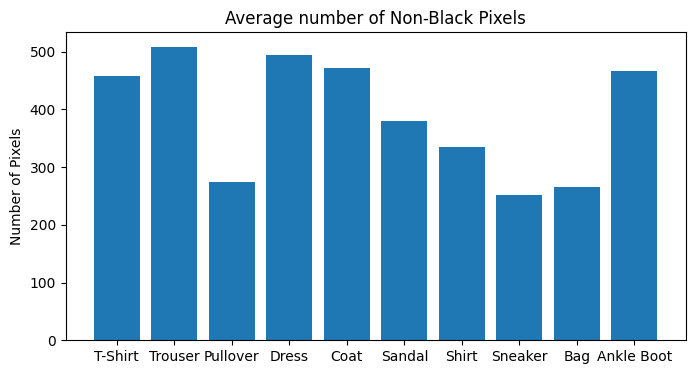

In [6]:
plt.figure(figsize=(8, 4))
plt.bar(labels.values(),nonzeros_count_avg)
plt.ylabel('Number of Pixels')
plt.title('Average number of Non-Black Pixels')

Text(0.5, 1.0, 'Average pixel value for each class')

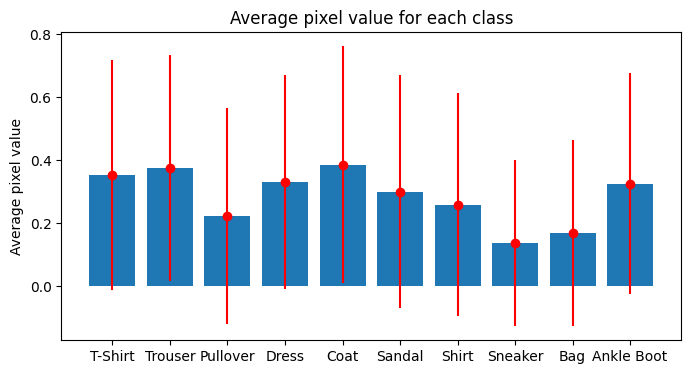

In [7]:
plt.figure(figsize=(8, 4))
plt.bar(labels.values(),avg_img_value[0:10])
plt.errorbar(labels.values(),avg_img_value[0:10], yerr = avg_img_value[10:20], fmt='o', color='r')
plt.ylabel('Average pixel value')
plt.title('Average pixel value for each class')

<function matplotlib.pyplot.show(close=None, block=None)>

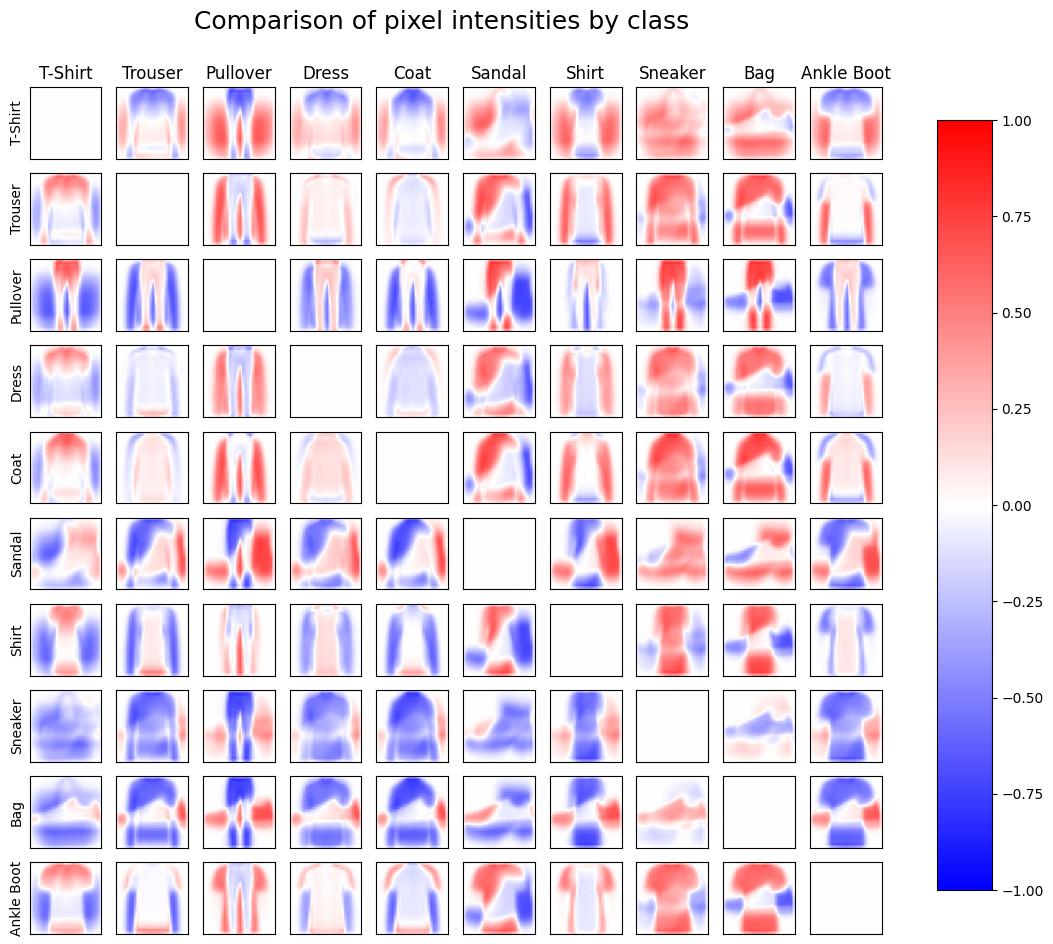

In [8]:
# pairwise comparison of classes

# define figure/subplots
fig = plt.figure(figsize=(11, 11))
#fig.subplots_adjust(hspace=0, wspace = 0)
fig.tight_layout()
fig.suptitle("Comparison of pixel intensities by class", fontsize=18, y=0.95)
p = 1;
for j, avg_outer in enumerate(img_means):
  for k, avg_inner in enumerate(img_means):
    # find difference between average of 2 classes
    diff1 = avg_outer - avg_inner

    # set axes and plot info
    ax = plt.subplot(10,10, p)
    im = ax.imshow(diff1, cmap="bwr", vmin = -1, vmax = 1 )
    #ax.set_title(labels[i_label])
    ax.set_xticks([])
    ax.set_yticks([])

    if j == 0:
      ax.set_title(labels[k])
    if k == 0:
      ax.set_ylabel(labels[j])

    p = p + 1



fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show

**Random Forest Classifier**

In [15]:
# fit random forest to training data
randForest = RandomForestClassifier(n_estimators=100, max_depth=45, random_state=0).fit(X_train.reshape([counts[0]*10, 28*28]), y_train)

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       900
           1       0.99      0.97      0.98       900
           2       0.79      0.82      0.81       900
           3       0.88      0.92      0.90       900
           4       0.79      0.83      0.81       900
           5       0.98      0.96      0.97       900
           6       0.74      0.61      0.67       900
           7       0.94      0.96      0.95       900
           8       0.95      0.97      0.96       900
           9       0.96      0.96      0.96       900

    accuracy                           0.89      9000
   macro avg       0.89      0.89      0.88      9000
weighted avg       0.89      0.89      0.88      9000



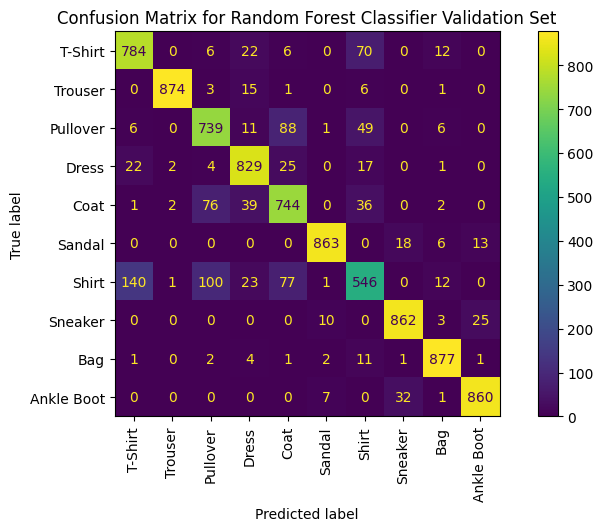

In [16]:
# predict classes for validation set
y_predVali = randForest.predict(X_vali.reshape([(6000-counts[0])*10, 28*28]))

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_vali, y_predVali, ax=ax)
ax.xaxis.set_ticklabels(labels.values(), rotation = 90)
ax.yaxis.set_ticklabels(labels.values())
_ = ax.set_title(
    f"Confusion Matrix for Random Forest Classifier Validation Set"
)

print(classification_report(y_vali, y_predVali))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.81      0.79      1000
           3       0.87      0.91      0.89      1000
           4       0.77      0.81      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.58      0.65      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



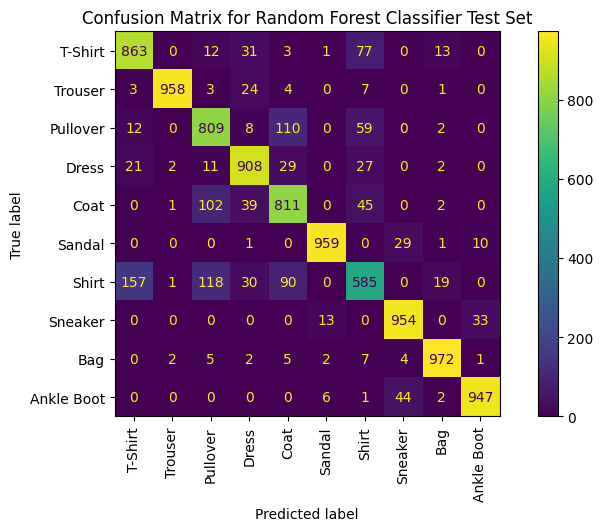

In [17]:
# predict classes for test set
y_predTest = randForest.predict(test_data.data.reshape([10000, 28*28]))

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(test_data.targets, y_predTest, ax=ax)
ax.xaxis.set_ticklabels(labels.values(), rotation = 90)
ax.yaxis.set_ticklabels(labels.values())
_ = ax.set_title(
    f"Confusion Matrix for Random Forest Classifier Test Set"
)

print(classification_report(test_data.targets, y_predTest))